# Importing the libraries

In [303]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from statsmodels.formula.api import ols
import scipy
from scipy import stats
from scipy.stats import norm
%matplotlib inline

# Loading and understanding data

In [233]:
# loading the file

data = pd.read_csv('sleepdata.csv', delimiter = ';')

In [234]:
# checking the shape of dataframe

data.shape

(270, 8)

In [235]:
# quick peek at the top 5 rows

data.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2013-03-10 11:41:32,2013-03-10 17:33:33,63%,5:52,NaN,NaN,NaN,0
1,2013-03-11 10:09:53,2013-03-11 17:49:49,82%,7:39,NaN,NaN,NaN,0
2,2013-03-12 10:35:15,2013-03-12 10:51:50,3%,0:16,NaN,NaN,NaN,0
3,2013-03-12 11:08:14,2013-03-12 11:24:05,3%,0:15,NaN,NaN,NaN,0
4,2013-03-12 11:24:19,2013-03-12 17:53:05,69%,6:28,NaN,NaN,NaN,0


In [236]:
# variables and their types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 8 columns):
Start               270 non-null object
End                 270 non-null object
Sleep quality       270 non-null object
Time in bed         270 non-null object
Wake up             107 non-null object
Sleep Notes         108 non-null object
Heart rate          99 non-null float64
Activity (steps)    270 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 17.0+ KB


# Cleaning and Validation

In [237]:
# removing spaces from the column names

data.rename(
  columns={
    'Sleep quality' : 'Sleep_quality',
    'Time in bed' : 'Time_in_bed',
    'Wake up' : 'Wake_up',
    'Sleep Notes' : 'Sleep_Notes',
    'Heart rate' : 'Heart_rate',
    'Activity (steps)' : 'Activity_steps',  
  },
  inplace=True
)
data.head()

,Start,End,Sleep_quality,Time_in_bed,Wake_up,Sleep_Notes,Heart_rate,Activity_steps
0,2013-03-10 11:41:32,2013-03-10 17:33:33,63%,5:52,NaN,NaN,NaN,0
1,2013-03-11 10:09:53,2013-03-11 17:49:49,82%,7:39,NaN,NaN,NaN,0
2,2013-03-12 10:35:15,2013-03-12 10:51:50,3%,0:16,NaN,NaN,NaN,0
3,2013-03-12 11:08:14,2013-03-12 11:24:05,3%,0:15,NaN,NaN,NaN,0
4,2013-03-12 11:24:19,2013-03-12 17:53:05,69%,6:28,NaN,NaN,NaN,0


In [238]:
# removing unwanted columns

df = data.drop(columns = ['Wake_up'])
df.shape

(270, 7)

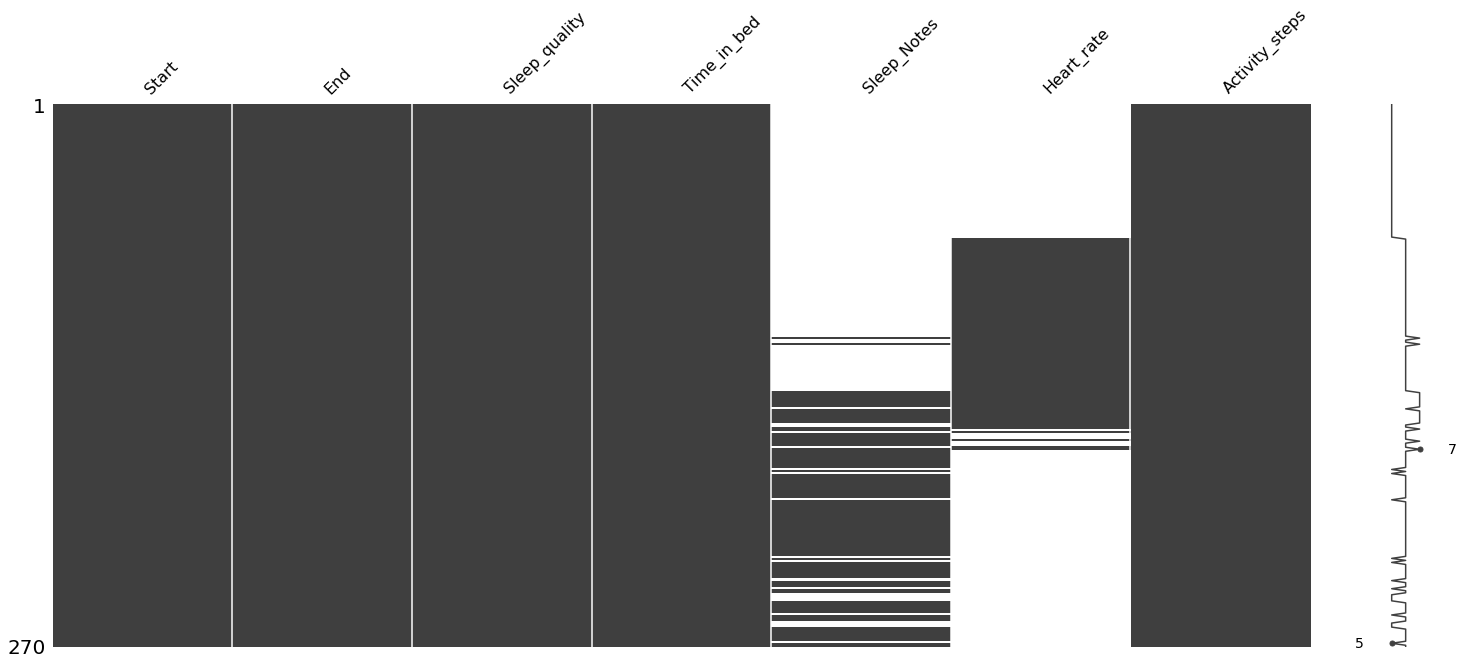

In [239]:
# cheking for missing data

msno.matrix(df);

# sleep_notes and heart-rate columns are missing values

In [240]:
# choosing only valid values in steps (min 1000 steps/day)

df = df.loc[df["Activity_steps"]>1000]
print(df.shape)
df.head()

(135, 7)


,Start,End,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps
115,2016-11-17 11:34:54,2016-11-17 18:13:30,70%,6:38,NaN,58.0,10583
116,2016-11-18 10:22:23,2016-11-18 17:31:49,73%,7:09,Stressful day,52.0,16053
117,2016-11-19 11:20:36,2016-11-19 19:00:07,80%,7:39,NaN,97.0,8794
118,2016-11-20 10:51:09,2016-11-20 18:00:29,75%,7:09,NaN,77.0,2622
119,2016-11-21 09:42:40,2016-11-21 18:02:36,88%,8:19,Stressful day,54.0,11744


In [241]:
# removing the % sign and moving into numerical values for sleep_quality column

df['Sleep_quality'] = [x.strip('\%') for x in df['Sleep_quality']]
df['Sleep_quality'] = pd.to_numeric(df['Sleep_quality'])

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 115 to 269
Data columns (total 7 columns):
Start             135 non-null object
End               135 non-null object
Sleep_quality     135 non-null int64
Time_in_bed       135 non-null object
Sleep_Notes       96 non-null object
Heart_rate        45 non-null float64
Activity_steps    135 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.4+ KB


In [243]:
# transforming the time in bed column into minutes

df['Time_in_bed'] = df['Time_in_bed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
df.head()

,Start,End,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps
115,2016-11-17 11:34:54,2016-11-17 18:13:30,70,398,NaN,58.0,10583
116,2016-11-18 10:22:23,2016-11-18 17:31:49,73,429,Stressful day,52.0,16053
117,2016-11-19 11:20:36,2016-11-19 19:00:07,80,459,NaN,97.0,8794
118,2016-11-20 10:51:09,2016-11-20 18:00:29,75,429,NaN,77.0,2622
119,2016-11-21 09:42:40,2016-11-21 18:02:36,88,499,Stressful day,54.0,11744


In [244]:
# removing non-informative values for sleep quality

df = df.loc[df["Sleep_quality"]>10]
df.shape

(133, 7)

In [245]:
# sparating date and time into two separate columns

df['Start_date'], df['Start_time'] = df['Start'].str.split(' ', 1).str

df.head()

,Start,End,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time
115,2016-11-17 11:34:54,2016-11-17 18:13:30,70,398,NaN,58.0,10583,2016-11-17,11:34:54
116,2016-11-18 10:22:23,2016-11-18 17:31:49,73,429,Stressful day,52.0,16053,2016-11-18,10:22:23
117,2016-11-19 11:20:36,2016-11-19 19:00:07,80,459,NaN,97.0,8794,2016-11-19,11:20:36
118,2016-11-20 10:51:09,2016-11-20 18:00:29,75,429,NaN,77.0,2622,2016-11-20,10:51:09
119,2016-11-21 09:42:40,2016-11-21 18:02:36,88,499,Stressful day,54.0,11744,2016-11-21,09:42:40


In [246]:
# removing the start and end columns

df = df.drop(["Start", "End"], axis=1)
df.head()

,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time
115,70,398,NaN,58.0,10583,2016-11-17,11:34:54
116,73,429,Stressful day,52.0,16053,2016-11-18,10:22:23
117,80,459,NaN,97.0,8794,2016-11-19,11:20:36
118,75,429,NaN,77.0,2622,2016-11-20,10:51:09
119,88,499,Stressful day,54.0,11744,2016-11-21,09:42:40


In [247]:
# converting to_datetime format

df.Start_date = pd.to_datetime(df.Start_date)

In [248]:
# adding Dayofweek column

df['Start_Dayofweek'] = df.Start_date.dt.day_name()
df.head()

,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time,Start_Dayofweek
115,70,398,NaN,58.0,10583,2016-11-17,11:34:54,Thursday
116,73,429,Stressful day,52.0,16053,2016-11-18,10:22:23,Friday
117,80,459,NaN,97.0,8794,2016-11-19,11:20:36,Saturday
118,75,429,NaN,77.0,2622,2016-11-20,10:51:09,Sunday
119,88,499,Stressful day,54.0,11744,2016-11-21,09:42:40,Monday


In [249]:
# cleaning the start_time column values

df.Start_time = df.Start_time.map(lambda x: str(x)[:2])
df["Start_time"] = pd.to_numeric(df["Start_time"])
df.head()

,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time,Start_Dayofweek
115,70,398,NaN,58.0,10583,2016-11-17,11,Thursday
116,73,429,Stressful day,52.0,16053,2016-11-18,10,Friday
117,80,459,NaN,97.0,8794,2016-11-19,11,Saturday
118,75,429,NaN,77.0,2622,2016-11-20,10,Sunday
119,88,499,Stressful day,54.0,11744,2016-11-21,9,Monday


In [250]:
# separating the notes column to crrate dummy variables

data_dummy_column=df[['Sleep_Notes']]
data_dummy_column.columns

Index(['Sleep_Notes'], dtype='object')

In [251]:
data_dummy_column['Sleep_Notes'] = data_dummy_column['Sleep_Notes'].fillna(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [252]:
#creating dummie variables

dummies = data_dummy_column['Sleep_Notes'].str.get_dummies(sep=':')
dummies.head()

,0,Ate late,Drank coffee,Drank tea,Stressful day,Worked out
115,1,0,0,0,0,0
116,0,0,0,0,1,0
117,1,0,0,0,0,0
118,1,0,0,0,0,0
119,0,0,0,0,1,0


In [253]:
# adding dummies to the main dataframe and creating the final version

df_full = df.join(dummies)
df_full.columns

Index(['Sleep_quality', 'Time_in_bed', 'Sleep_Notes', 'Heart_rate',
       'Activity_steps', 'Start_date', 'Start_time', 'Start_Dayofweek', '0',
       'Ate late', 'Drank coffee', 'Drank tea', 'Stressful day', 'Worked out'],
      dtype='object')

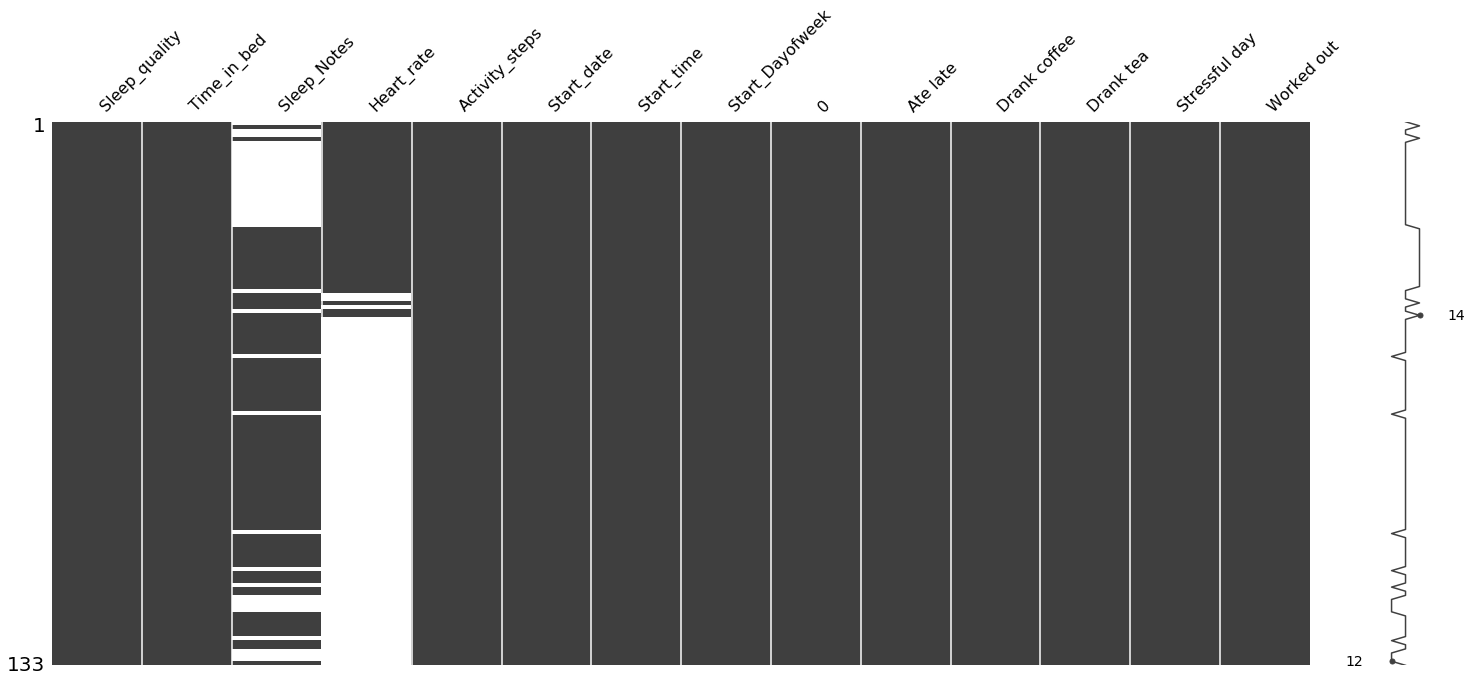

In [254]:
# assessing missing values in the full dataframe

msno.matrix(df_full);

In [255]:
# removing the 'Worked out', 'Drank tea' column since all entries are not informative; also removing 0 column 

df_full= df_full.drop(['Worked out', '0', 'Drank tea', 'Sleep_Notes', 'Heart_rate'], axis=1)             

In [256]:
df_full.head() 

,Sleep_quality,Time_in_bed,Activity_steps,Start_date,Start_time,Start_Dayofweek,Ate late,Drank coffee,Stressful day
115,70,398,10583,2016-11-17,11,Thursday,0,0,0
116,73,429,16053,2016-11-18,10,Friday,0,0,1
117,80,459,8794,2016-11-19,11,Saturday,0,0,0
118,75,429,2622,2016-11-20,10,Sunday,0,0,0
119,88,499,11744,2016-11-21,9,Monday,0,0,1


In [257]:
# removing the spaces from the new column names

df_full.rename(
  columns={
    'Ate late' : 'Ate_late',
    'Drank coffee' : 'Drank_coffee',
    'Drank tea': 'Drank_tea',
    'Stressful day': 'Stressful_day'  
  },
  inplace=True
)
df_full

,Sleep_quality,Time_in_bed,Activity_steps,Start_date,Start_time,Start_Dayofweek,Ate_late,Drank_coffee,Stressful_day
115,70,398,10583,2016-11-17,11,Thursday,0,0,0
116,73,429,16053,2016-11-18,10,Friday,0,0,1
117,80,459,8794,2016-11-19,11,Saturday,0,0,0
118,75,429,2622,2016-11-20,10,Sunday,0,0,0
119,88,499,11744,2016-11-21,9,Monday,0,0,1
120,82,466,10437,2016-11-22,10,Tuesday,0,0,0
121,79,450,11113,2016-11-23,10,Wednesday,0,0,0
122,84,484,10919,2016-11-24,10,Thursday,0,0,0
123,86,490,9250,2016-11-25,9,Friday,0,0,0
124,68,365,13595,2016-11-26,11,Saturday,0,0,0


In [273]:
# checking if stress column contain enough data for analysis

stress = df_full.Stressful_day

In [281]:
stress.value_counts().sort_index()   # looks ok

0    83
1    50
Name: Stressful_day, dtype: int64

In [282]:
# checking if coffee column contain enough data for analysis

coffee = df_full.Drank_coffee

In [276]:
coffee.value_counts().sort_index()   # looks ok

0    80
1    53
Name: Drank_coffee, dtype: int64

In [284]:
# checking if ate alte column contain enough data for analysis

food = df_full.Ate_late

In [283]:
food.value_counts().sort_index()   # small ammount of occurences can affect the regression

0    115
1     18
Name: Ate_late, dtype: int64

In [285]:
# checking mins and maxs

round(df_full.describe(), 2)

,Sleep_quality,Time_in_bed,Activity_steps,Start_time,Ate_late,Drank_coffee,Stressful_day
count,133.00,133.00,133.00,133.00,133.00,133.00,133.00
mean,73.05,419.17,9429.39,10.50,0.14,0.40,0.38
std,14.31,73.78,3630.93,1.31,0.34,0.49,0.49
min,27.00,226.00,1222.00,7.00,0.00,0.00,0.00
25%,64.00,366.00,7191.00,10.00,0.00,0.00,0.00
50%,74.00,417.00,9049.00,10.00,0.00,0.00,0.00
75%,83.00,474.00,11277.00,11.00,0.00,1.00,1.00
max,100.00,593.00,21892.00,14.00,1.00,1.00,1.00


# EDA & Visualisations

In [286]:
# looking at correlation between vaiables

round(df_full.corr(), 2)

,Sleep_quality,Time_in_bed,Activity_steps,Start_time,Ate_late,Drank_coffee,Stressful_day
Sleep_quality,1.00,0.81,-0.21,-0.75,0.13,-0.16,0.00
Time_in_bed,0.81,1.00,-0.15,-0.71,0.04,-0.15,-0.09
Activity_steps,-0.21,-0.15,1.00,0.21,0.05,0.01,0.03
Start_time,-0.75,-0.71,0.21,1.00,0.05,0.11,-0.01
Ate_late,0.13,0.04,0.05,0.05,1.00,0.17,0.10
Drank_coffee,-0.16,-0.15,0.01,0.11,0.17,1.00,0.03
Stressful_day,0.00,-0.09,0.03,-0.01,0.10,0.03,1.00


In [288]:
# which ones are highly correlated?

abs(df_full.corr()) > 0.75

,Sleep_quality,Time_in_bed,Activity_steps,Start_time,Ate_late,Drank_coffee,Stressful_day
Sleep_quality,True,True,False,True,False,False,False
Time_in_bed,True,True,False,False,False,False,False
Activity_steps,False,False,True,False,False,False,False
Start_time,True,False,False,True,False,False,False
Ate_late,False,False,False,False,True,False,False
Drank_coffee,False,False,False,False,False,True,False
Stressful_day,False,False,False,False,False,False,True


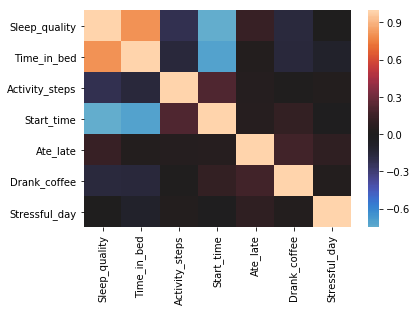

In [261]:
# corr heatmap

sns.heatmap(df_full.corr(), center=0);

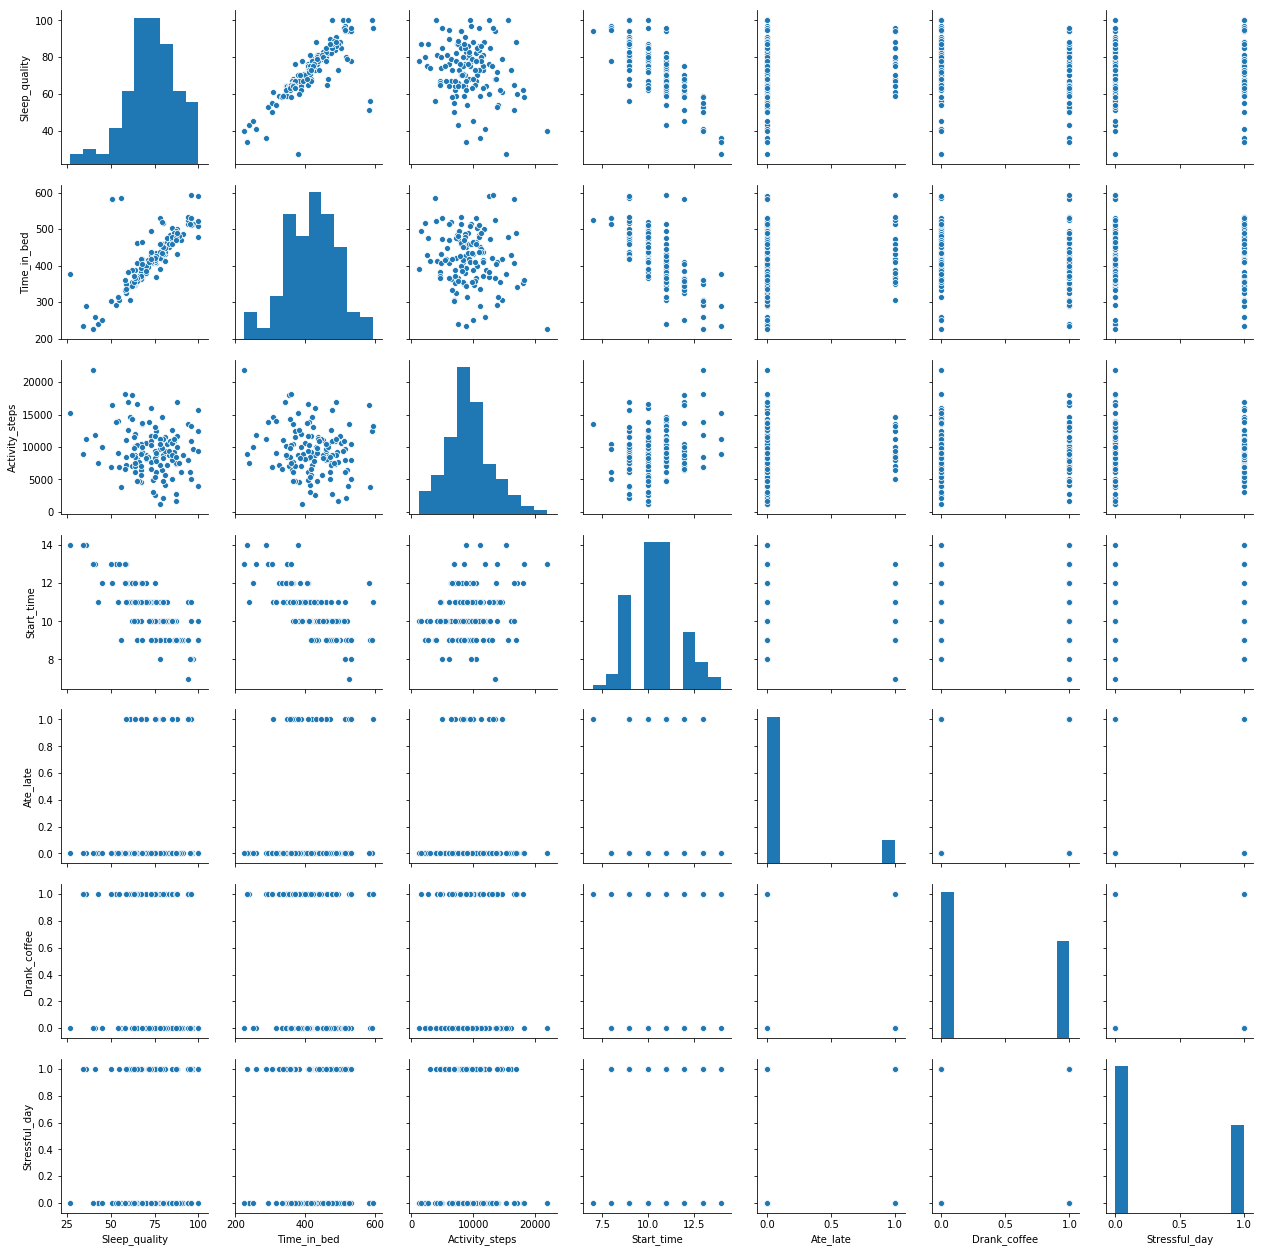

In [263]:
# a quick visualisation of corr and distributions

sns.pairplot(df_full);

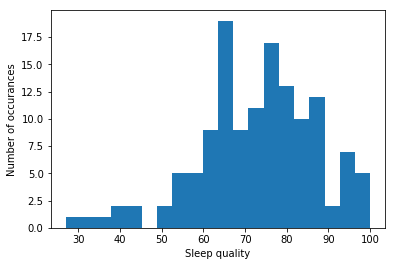

In [289]:
# histogram of sleep quality index

plt.hist(df_full.Sleep_quality, bins=20)
plt.xlabel('Sleep quality')
plt.ylabel('Number of occurances')
plt.show()

Text(0, 0.5, 'PMF')

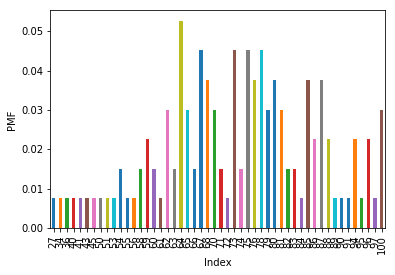

In [324]:
# sleep quality PMF

pmf_sleep = df_full.Sleep_quality.value_counts().sort_index() / len(df_full.Sleep_quality)
pmf_sleep.plot(kind='bar');
plt.xlabel('Index')
plt.ylabel('PMF')

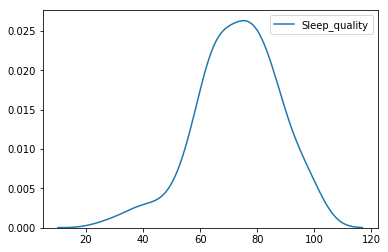

In [329]:
# KDE plot 

sns.kdeplot(df_full.Sleep_quality);

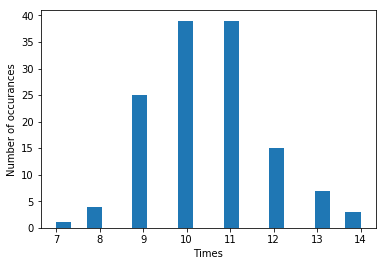

In [292]:
# histogram of going to bed hours

plt.hist(df_full.Start_time, bins=20)
plt.xlabel('Times')
plt.ylabel('Number of occurances')
plt.show()

Text(0, 0.5, 'PMF')

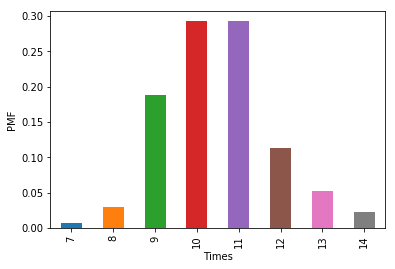

In [325]:
# going to bed times PMF

pmf_times = df_full.Start_time.value_counts().sort_index() / len(df_full.Start_time)
pmf_times.plot(kind='bar');
plt.xlabel('Times')
plt.ylabel('PMF')

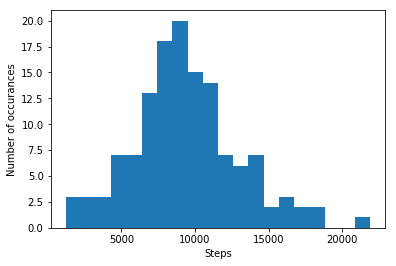

In [295]:
# histogram of number of steps

plt.hist(df_full.Activity_steps, bins=20)
plt.xlabel('Steps')
plt.ylabel('Number of occurances')
plt.show()

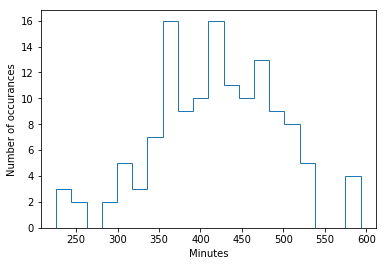

In [298]:
# histogram of number of hours spent in bed

plt.hist(df_full.Time_in_bed, bins=20, histtype='step') # changing the histtype for fun
plt.xlabel('Minutes')
plt.ylabel('Number of occurances')
plt.show()

Text(0, 0.5, 'PMF')

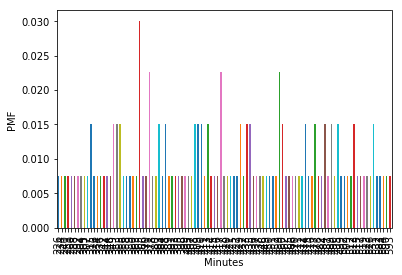

In [326]:
# hours spent in bed PMF

pmf_len = df_full.Time_in_bed.value_counts().sort_index() / len(df_full.Time_in_bed)
pmf_len.plot(kind='bar');
plt.xlabel('Minutes')
plt.ylabel('PMF')

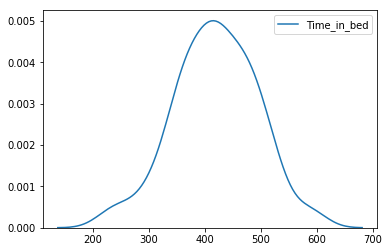

In [330]:
# KDE plot 

sns.kdeplot(df_full.Time_in_bed);

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


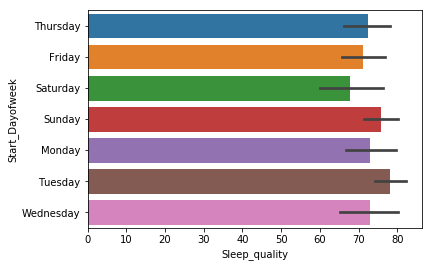

In [264]:
# quality of sleep by day of the week

sns.barplot(x=df_full['Sleep_quality'], y=df_full['Start_Dayofweek'], data=df_full);

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


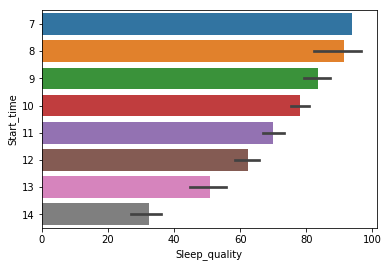

In [266]:
# sleep quality by times

sns.barplot(x=df_full['Sleep_quality'], y=df_full['Start_time'], data=df_full, orient='h');

## See if any of the variable's log's fit normal distribution

# Single variable regression

In [335]:
# quick regression

xs = df_full.Time_in_bed
ys = df_full.Sleep_quality
res = scipy.stats.linregress(xs, ys)
res

LinregressResult(slope=0.15650489648429158, intercept=7.443673127046836, rvalue=0.8066229586727994, pvalue=1.0433099091152846e-31, stderr=0.010019773882471607)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


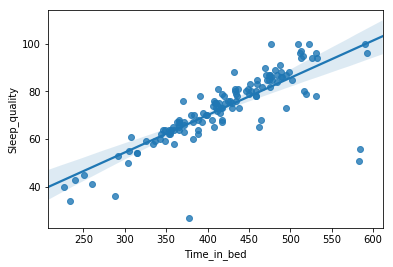

In [338]:
# plotting the line of best fit

sns.regplot(xs, ys)

### Building the model

In [271]:
# constructing linear model 

lr_model = ols(formula='Sleep_quality~Time_in_bed', data=df_full).fit()
lr_model.summary()

# warns about multicollinearity even though one variable?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Sleep_quality   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     244.0
Date:                Tue, 16 Apr 2019   Prob (F-statistic):           1.04e-31
Time:                        14:36:03   Log-Likelihood:                -472.23
No. Observations:                 133   AIC:                             948.5
Df Residuals:                     131   BIC:                             954.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.4437      4.264      1.746      0.083      -0.992      15.879
Time_in_bed     0.1565      0.010     15.620      0.000       0.137       0.176
==============================================================================
Omnibus:                      116.898   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1311.123
Skew:                          -3.099   Prob(JB):                    1.96e-285
Kurtosis:                      17.078   Cond. No.                     2.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Assessing the model

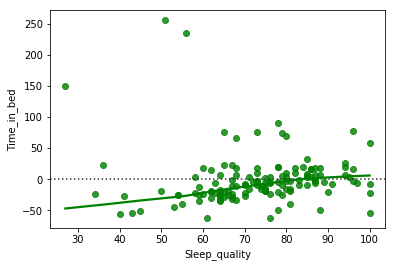

In [269]:
# residuals plot for quality vs duration

sns.residplot(df_full['Sleep_quality'], df_full['Time_in_bed'], lowess=True, color="g");

In [36]:
# checking for ... :

pred_val = lr_model.fittedvalues.copy()
true_val = df_full['Sleep_quality'].values.copy()
residual = true_val - pred_val

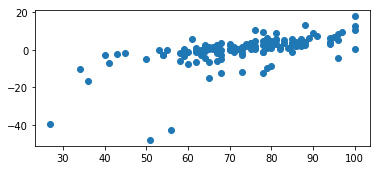

In [37]:
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(df_full['Sleep_quality'],residual)

0.9523990893322951

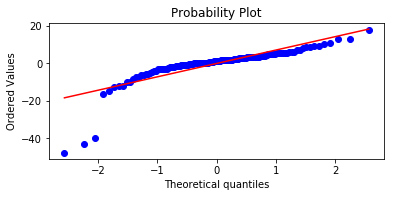

In [38]:
# checking for normality - QQ plot 

import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
sp.stats.probplot(residual, plot=ax, fit=True)
#r**2
0.9523990893322951


# obviously not normally distributed

## Data transformation 

### Log

In [97]:
# subseting variables for logging to see if works

sub_logged = df_full[['Sleep_quality', 'Time_in_bed']]
sub_logged.head()

,Sleep_quality,Time_in_bed
115,70,398
116,73,429
117,80,459
118,75,429
119,88,499


In [99]:
sub_logged['Sleep_quality_log'] = np.log(df_full['Sleep_quality'])
sub_logged['Time_in_bed_log'] = np.log(df_full['Time_in_bed'])
sub_logged.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

,Sleep_quality,Time_in_bed,Sleep_quality_log,Time_in_bed_log
115,70,398,4.248495,5.986452
116,73,429,4.290459,6.061457
117,80,459,4.382027,6.129050
118,75,429,4.317488,6.061457
119,88,499,4.477337,6.212606


In [41]:
# performing logged regression

lr_model_reg = ols(formula='Sleep_quality_log~Time_in_bed_log', data=sub_logged).fit()
lr_model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Sleep_quality_log   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     238.1
Date:                Sat, 13 Apr 2019   Prob (F-statistic):           2.96e-31
Time:                        13:33:32   Log-Likelihood:                 81.097
No. Observations:                 133   AIC:                            -158.2
Df Residuals:                     131   BIC:                            -152.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.4708      0.372     -3.952      0.000      -2.207      -0.735
Time_in_bed_log     0.9532      0.062     15.429      0.000       0.831       1.075
==============================================================================
Omnibus:                      146.888   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2850.354
Skew:                          -4.072   Prob(JB):                         0.00
Kurtosis:                      24.166   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# residuals of logged model

pred_val_log = lr_model_reg.fittedvalues.copy()
true_val_log = sub_logged['Sleep_quality_log'].values.copy()
residual_log = true_val_log - pred_val_log

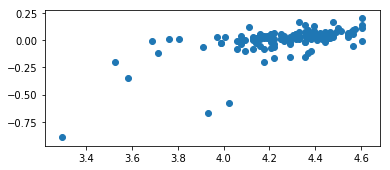

In [43]:
# visualising logged residuals

fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(sub_logged['Sleep_quality_log'],residual_log)

0.9523990893322951

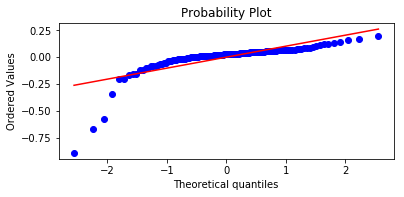

In [101]:
# checking for log normality - QQ plot 

fig, ax = plt.subplots(figsize=(6,2.5))
sp.stats.probplot(residual_log, plot=ax, fit=True)
#r**2
0.9523990893322951

# still not normal :(